In [1]:
# Import necessary packages
import torch
from torch import nn
from IPython import display
import os
import torch.nn.functional as F
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import datetime

# 1. Read the CIFAR10 dataset and create Data Loader

In [2]:
# Define data transformation to be used for the dataset
## Augmentation transformation applied to training set
augmentation = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5), # Random flip in horizontal way
     transforms.RandomCrop(32, padding=4), # Random crop
     transforms.RandomRotation(10), # Random rotation
     transforms.ToTensor(), # Convert data to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize the data
## Transformation applied to validation and test set
transform = transforms.Compose(
    [transforms.ToTensor(), # Convert data to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize the data

# Define batch_size
batch_size = 128

# Load/Read training and validation data
## 1 set with normal transform and another set with augmentation
trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=augmentation)
## Split the data randomly into training and validation (fixed the seed for easy performance comparison)
trainset1, valset1 = torch.utils.data.random_split(trainset1, [40000, 10000], generator=torch.Generator().manual_seed(306))
trainset2, valset2 = torch.utils.data.random_split(trainset2, [40000, 10000], generator=torch.Generator().manual_seed(306))

# Create DataLoader training and validation data
## For training set, create DataLoader the combined trainset (trainset1 + transet2)
### Combine 2 training sets together (1 normal + 1 augmentation)
trainset = torch.utils.data.ConcatDataset((trainset1, trainset2))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
## For validation set, create DataLoader the valset that is transformed without augmentation (valset1)
valloader = torch.utils.data.DataLoader(valset1, batch_size=batch_size, shuffle=True, num_workers=2)


# Load/Read test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Create DataLoader test data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Check the size/len of the dataset

In [3]:
print('The size of training data:', len(trainset))
print('The size of validation data:', len(valset1))
print('The size of test data:', len(testset))

The size of training data: 80000
The size of validation data: 10000
The size of test data: 10000


Get some random training images

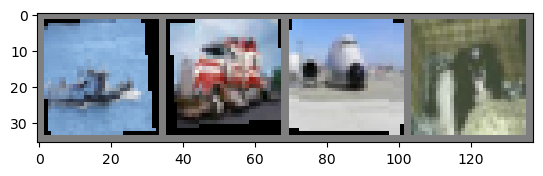

ship  truck plane dog  


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))

# print labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# 2. Create the model

## Define a function to calculate the weight to combine k convolutional outputs

In [5]:
# Define the weight 'a' to combine different outputs generated by convolutional layers of a block
def define_a(x, num_convs):
    avgpool = nn.AdaptiveAvgPool2d(7) # Spatial Average Pool
    spatial_avg = avgpool(x)
    spatial_avg = spatial_avg.view(spatial_avg.size(0), -1) # Flatten
    
    # MLP layer
    mlp_weights = nn.Sequential(nn.Linear(spatial_avg.size(1), 64),
                                        nn.Linear(64,32),
                                        nn.Linear(32, num_convs),
                               ).to(device)
    # Generate the weight 'a' with Sigmoid() activation, MLP and Spatial Average Pool
    a = nn.Sigmoid()(mlp_weights(spatial_avg)) # activation g = Sigmoid()
    
    return a

## Construct a block architecture

In [6]:
# Define a block architecture
class Block(nn.Module):
    def __init__(self, num_convs, input_channels, output_channels):
        super(Block, self).__init__()
        self.num_convs = num_convs # Set variable: number of convolutional layers
        self.input_channels = input_channels # Set variable: number of input channels
        self.output_channels = output_channels # Set variable: number of output channels
        
        ## Set up each convolutional layers, together with Batch Normalization and ReLU activation function
        for i in range(num_convs):
            ### Convolutional layer
            self.add_module('conv{0}'.format(i), nn.Conv2d(input_channels, output_channels, kernel_size=3, padding = 1))
            ### Batch Normalization
            self.add_module('bn{0}'.format(i), nn.BatchNorm2d(output_channels))
            ### Activation function: ReLU()
            self.add_module('relu{0}'.format(i), nn.ReLU())
        
        ## Max Pooling layer to reduce spatial dimension of the data
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        a = define_a(x, self.num_convs) # Generate weights to combine the convolutional outputs
        a = torch.split(a, 1, dim=1) # Split the weights into different weight tensors to be used separately with each convolutional output
        
        out = [] # Store outputs generated from parallel convolutional layers
        for i in range(self.num_convs):
            conv = self._modules['conv{0}'.format(i)](x) # Send input to convolutional layer in a parallel way
            conv = self._modules['bn{0}'.format(i)](conv) # Apply batch normalization
            conv = self._modules['relu{0}'.format(i)](conv) # Apply ReLU() activation function
            convo_output = conv*a[i].unsqueeze(-1).unsqueeze(-1) # Multily the convolutional output with a weight tensor
            out.append(convo_output)
        
        out = self.max_pool(sum(out)) # Sum the outputs obtained from the loop above and sent it to Max Pooling layer
        
        return out

## Construct a backbone architecture

In [7]:
# Define a backbone architecture
class Backbone(nn.Module):
    def __init__(self, conv_arch, dropout_rate):
        super(Backbone, self).__init__()
        in_channels = 3 # Set variable: number of input channels for the FIRST block
        self.conv_arch = conv_arch # Set variable: a tuple of (number of convolutional layers, number of output channels)
        self.dropout_rate = dropout_rate # Set variable: dropout rate
        
        ## Set up the backbone with sequential blocks
        for i, (num_convs, out_channels) in enumerate(conv_arch):
            self.add_module('Block{0}'.format(i), Block(num_convs, in_channels, out_channels)) # Block
            in_channels = out_channels # Set up a dynamic flow among blocks: input of the current block = output of the previous block
        
        self.mean_feature = nn.AdaptiveAvgPool2d(1) # Define Spatial Avg Pool for the output of the LAST block
        
        ## Define the classifier (3 Fully Connected layers + ReLU() + Dropout layer)
        self.last = nn.Sequential(nn.Flatten(),
                                 nn.Linear(out_channels, 128),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_rate),
                                 nn.Linear(128, 128),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_rate),
                                 nn.Linear(128, 10))
    
    def forward(self, x):
        out = x
        for i in range(len(self.conv_arch)):
            out = self._modules['Block{0}'.format(i)](out) # Send input to each block
        out = self.mean_feature(out) # Apply Spatial Avg Pool to the output of the LAST block
        out = self.last(out) # Apply the classifier
        
        return out

## Define a function to initialize weights for layers within the backbone

In [8]:
# Define a function to initialize the weight
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_normal_(m.weight)

## Initialize the model

In [9]:
# Set up GPU resource
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(True) # Enable GPU
torch.cuda.empty_cache() # Clear cuda cache (if any)

# Implement CNN
## Define number of blocks, number of convolutional within a block and number of output channels within a block
conv_arch = ((2, 64), (3, 128), (4, 256), (5, 512), (5, 512)) # 5 blocks: (num_conv, out_channels)
## Model initialization
model = Backbone(conv_arch, dropout_rate=0.3).to(device)
## Weights initialization
model.apply(init_weights)

Backbone(
  (Block0): Block(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Block1): Block(
    (conv0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): Batc

# 3. Create the loss and optimizer

## Loss function

Use Cross Entropy Loss

In [10]:
loss = nn.CrossEntropyLoss()

## Optimizer

Use Stochastic Gradient Descent optimizer (SGD)

In [11]:
lr = 0.1 #learning rate
wd=0.0001 #weight decay (regularization)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

# 4. Train the model

## Define some necessary function used in training the model and evaluating performance

The script is taken from the 'my_utils' material

In [12]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    # print(metric[0] / metric[1])
    return metric[0] / metric[1]

## Training script

The script is inspired from the 'my_utils' material

In [13]:
# Train one epoch
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=256, num_outputs=10):  
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
        
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        ## Compute gradients and update parameters
        X, y = X.to(device), y.to(device) # Set up to use GPU when training data
        y_hat = net(X) # Apply forward function of the backbone to the input
        l = loss(y_hat, y) # Apply loss function
        optimizer.zero_grad() # Set the gradients to zero
        l.backward() # back propagation
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel()) # Add up the loss and accuracy, train label size
    
    return metric[0] / metric[2], metric[1] / metric[2] # Return training loss (avg) and training accuracy (avg)

# Timer function to calculate the total time spent for training
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Train the whole model
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):  
    loss_result = []
    train_acc_result = []
    test_acc_result = []
    
    ## Train the model by looping each epoch
    for epoch in range(num_epochs):
        start_time = time.time() # Set start time for timer when starting training the epoch
        
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer) # Train the epoch
        test_acc = evaluate_accuracy(net, test_iter) # Calculate accuracy on test or validation set when done training the epoch
        
        end_time = time.time() # Set start time for timer when finishing training the epoch
        epoch_mins, epoch_secs = epoch_time(start_time, end_time) # Calculate total time to train 1 epoch
        ct = datetime.datetime.now()
        
        loss_result.append(train_metrics[0])
        train_acc_result.append(train_metrics[1])
        test_acc_result.append(test_acc)
        
        ### Print out the result: epoch train time, training loss, training accuracy, test/validation accuracy
        print('Epoch{0}: '.format(epoch),'| Epoch Time: ', epoch_mins,'m', epoch_secs, 's', '| Epoch Timestamp: ', ct)
        print('\tLoss= ',train_metrics[0], '| Train-Accuracy= ', train_metrics[1])
        print('\tValidation-Accuracy= ', test_acc)
    
    return loss_result, train_acc_result, test_acc_result

## Start training

In [14]:
# Set number of epoches for training
num_epochs = 100

# Train
result = train_ch3(model, trainloader, valloader, loss, num_epochs, optimizer)

Epoch0:  | Epoch Time:  0 m 55 s | Epoch Timestamp:  2023-04-13 06:54:54.634226
	Loss=  2.064892971038818 | Train-Accuracy=  0.1939375
	Validation-Accuracy=  0.2423
Epoch1:  | Epoch Time:  0 m 52 s | Epoch Timestamp:  2023-04-13 06:55:47.484429
	Loss=  1.7607511707305907 | Train-Accuracy=  0.3050875
	Validation-Accuracy=  0.4034
Epoch2:  | Epoch Time:  0 m 51 s | Epoch Timestamp:  2023-04-13 06:56:39.131918
	Loss=  1.4601235382080078 | Train-Accuracy=  0.442425
	Validation-Accuracy=  0.5063
Epoch3:  | Epoch Time:  0 m 52 s | Epoch Timestamp:  2023-04-13 06:57:31.490636
	Loss=  1.2598432856559754 | Train-Accuracy=  0.5292125
	Validation-Accuracy=  0.5959
Epoch4:  | Epoch Time:  0 m 51 s | Epoch Timestamp:  2023-04-13 06:58:23.318712
	Loss=  1.1001391764640809 | Train-Accuracy=  0.604575
	Validation-Accuracy=  0.6382
Epoch5:  | Epoch Time:  0 m 51 s | Epoch Timestamp:  2023-04-13 06:59:15.163484
	Loss=  0.9760783306121826 | Train-Accuracy=  0.6612125
	Validation-Accuracy=  0.7014
Epoch6:

Epoch50:  | Epoch Time:  0 m 51 s | Epoch Timestamp:  2023-04-13 07:37:51.426133
	Loss=  0.1566877237379551 | Train-Accuracy=  0.9512
	Validation-Accuracy=  0.8669
Epoch51:  | Epoch Time:  0 m 51 s | Epoch Timestamp:  2023-04-13 07:38:43.025876
	Loss=  0.15627773100733758 | Train-Accuracy=  0.9507
	Validation-Accuracy=  0.8653
Epoch52:  | Epoch Time:  0 m 52 s | Epoch Timestamp:  2023-04-13 07:39:35.052977
	Loss=  0.1512328812122345 | Train-Accuracy=  0.9524375
	Validation-Accuracy=  0.8715
Epoch53:  | Epoch Time:  0 m 51 s | Epoch Timestamp:  2023-04-13 07:40:26.508735
	Loss=  0.1496945570230484 | Train-Accuracy=  0.9532
	Validation-Accuracy=  0.8664
Epoch54:  | Epoch Time:  0 m 51 s | Epoch Timestamp:  2023-04-13 07:41:17.691539
	Loss=  0.1446505817592144 | Train-Accuracy=  0.954
	Validation-Accuracy=  0.8712
Epoch55:  | Epoch Time:  0 m 51 s | Epoch Timestamp:  2023-04-13 07:42:08.868625
	Loss=  0.14307480670809747 | Train-Accuracy=  0.95465
	Validation-Accuracy=  0.8711
Epoch56:  |

## Plotting the loss curve, training accuracy curve and validation accuracy curve

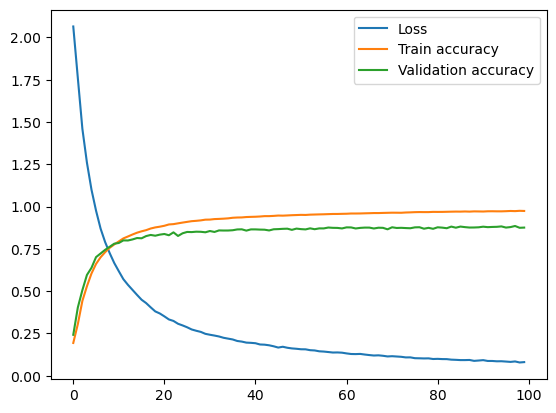

In [15]:
epoch_num = list(range(100))
loss = result[0]
train_acc = result[1]
test_acc = result[2]

plt.plot(epoch_num, loss, label='Loss') # Training loss
plt.plot(epoch_num, train_acc, label='Train accuracy') # Training accuracy
plt.plot(epoch_num, test_acc, label='Validation accuracy') # Validation accuracy
plt.legend()

# 5. Final model accuracy on CIFAR10 test set

In [16]:
test_acc = evaluate_accuracy(model, testloader)
print('Accuracy on test set is: ', test_acc)

Accuracy on test set is:  0.8704
